# import

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.utils import resample
from yellowbrick.datasets import load_concrete
import warnings
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

%matplotlib inline

# Load Data

In [3]:
_  = os.path.join('data', 'credit_train.csv')
bank_df = pd.read_csv(_)

# Methods/Constants/Globals

In [4]:
%run -i "scripts//methods_globals_constants.py"

# Clean Data

In [30]:
clean_df = bank_df.copy()

In [31]:
# Remove all rows where all the columns are nan/null. Removes ~ 500 observations
clean_df.dropna(axis=0, how='all', inplace=True)

In [32]:
# Remove all observation with credit scores higher than 900. These an enigma borrower and only account for ~4% of the data
_ = clean_df[clean_df['Credit Score'] <= 900].index
clean_df.drop(_, inplace=True) 

In [33]:
# There were too many missing values in these columns. We removed both to perserve as much data as possible.
clean_df.drop(['Credit Score', 'Annual Income'], axis=1, inplace=True) 

In [34]:
# Dropiing to nan value of year in current job. There are ~ 1056 which is ~ 4.45% of the remaining
_ = clean_df[clean_df['Years in current job'].isna()].index
clean_df.drop(_, inplace=True) 

In [35]:
# Fill in all nan values for "months since last delinquent" with the mean of the catagorical column Purpose
_ = clean_df.groupby('Purpose').mean()['Months since last delinquent'] # A temporary dictionary like object. also called a pandas series

clean_df = clean_df.apply(lambda x : fillna_average_by_target_column(row=x, 
                                                          avg_dict=_, 
                                                          target_col=7, 
                                                          effected_col=10),axis=1)

In [36]:
# Drop the remaining nan values in Maximun open credit, bankruptcies, and tax liens
clean_df.dropna( subset=['Maximum Open Credit', 'Bankruptcies', 'Tax Liens'], axis=0, inplace=True)

In [37]:
#Drop all loans amount with 9999999999. This is too extreme 
_ = clean_df.loc[clean_df['Current Loan Amount'] >= 99999999.0].index
clean_df.drop(index=_, inplace=True)

# Data Prep

In [38]:
clean_df.drop(['Loan ID', 'Customer ID'], axis=1, inplace=True)

In [39]:
prep_df = clean_df.copy()
prep_df.reset_index(drop=True, inplace=True)

In [40]:
# Label Encoding term with label encoding because it is binary
le = LabelEncoder()
prep_df['Term'] = le.fit_transform(prep_df['Term']) 

In [41]:
# One hot encoding all other object columns

ohe = OneHotEncoder(drop="first")
cat_var = prep_df.select_dtypes(include="object")
array_to_df = ohe.fit_transform(cat_var).toarray()  # Array values of the transformed columns
encoded = pd.DataFrame(array_to_df, columns=ohe.get_feature_names(cat_var.columns))  # Creating a pandas dataframe
prep_df = prep_df.join(encoded, how="left")

In [42]:
# Getting ride of all object columns for the model
_ = prep_df.select_dtypes(include="object").columns
prep_df.drop(columns=_, axis=1, inplace=True)

In [43]:
# Fixing class imbalance

majority_df = prep_df[prep_df['Loan Status_Fully Paid']==1]

minority_df = prep_df[prep_df['Loan Status_Fully Paid']==0]
minority_df = resample(minority_df, replace=True, n_samples=13200, random_state=123)

prep_df = pd.concat([majority_df, minority_df])

In [44]:
# Preparing the X,y train test data
X = prep_df.drop(columns='Loan Status_Fully Paid', axis=1)
y = prep_df['Loan Status_Fully Paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

# Modeling

### <span style="color:blue">------------------------------------------Base Line Model Logistic Regresssion------------------------------------------ </span>

Model can only do slightly better than random guesses.

Train Accuracy 0.5545454545454546
Test Accuracy 0.5452651515151515


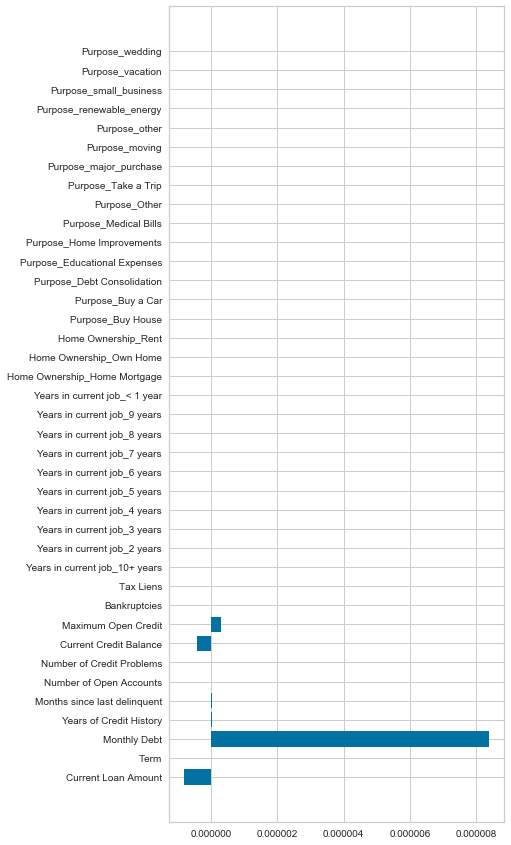

In [53]:
logr_clf = LogisticRegression()
logr_clf.fit(X_train, y_train)
y_pred = logr_clf.predict(X_train)

print('Train Accuracy', logr_clf.score(X_train, y_train))
print('Test Accuracy', logr_clf.score(X_test, y_test))
fig, ax = plt.subplots(figsize=(6, 15))
ax.barh(y=X_train.columns, width=logr_clf.coef_[0]);

### <span style="color:blue">------------------------------------------ Random Forest------------------------------------------</span>

Train Accuracy 0.7232481060606061
Test Accuracy 0.6558712121212121
OOB Score 0.6489109848484849


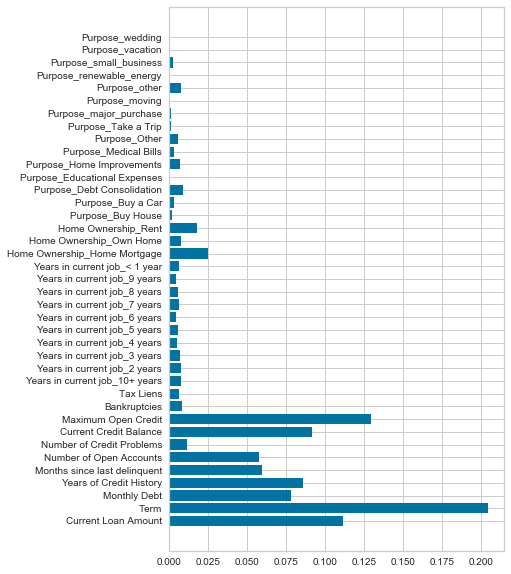

In [56]:
rf_clf = RandomForestClassifier(n_estimators= 300, 
                                criterion= 'gini', 
                                max_depth= 10, 
                                max_features= 'auto',
                                oob_score= True)
rf_clf.fit(X_train, y_train.ravel())

accuracy_train = rf_clf.score(X_train, y_train)
accuracy_test = rf_clf.score(X_test, y_test)
oob = rf_clf.oob_score_

print('Train Accuracy', accuracy_train)
print('Test Accuracy', accuracy_test)
print('OOB Score', oob)

fig, ax = plt.subplots(figsize=(6, 10))
ax.barh(width=rf_clf.feature_importances_, y=X_train.columns);

### <span style="color:blue">------------------------------------------ GradientBoostingClassifier------------------------------------------</span>

Train Accuracy 0.6464015151515151
Test Accuracy 0.6204545454545455


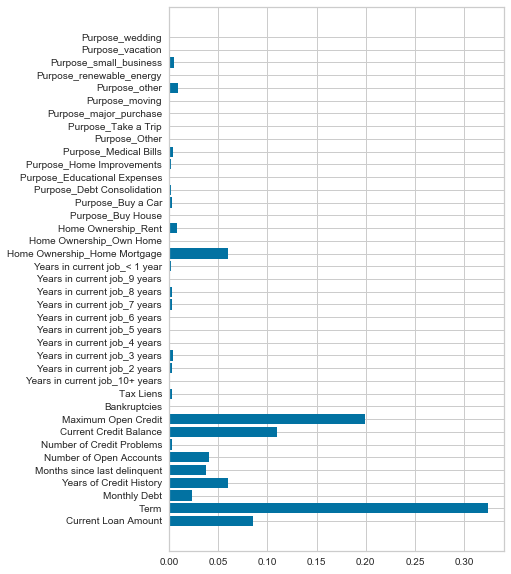

In [59]:
gbc = GradientBoostingClassifier(random_state=42)

gbc.fit(X_train, y_train)

accuracy_train = gbc.score(X_train, y_train.ravel())
accuracy_test = gbc.score(X_test, y_test.ravel())

print('Train Accuracy', accuracy_train)
print('Test Accuracy', accuracy_test)

fig, ax = plt.subplots(figsize=(6, 10))
ax.barh(width=gbc.feature_importances_, y=X_train.columns);

### <span style="color:blue">------------------------------------------AdaBoostClassifier------------------------------------------</span>

Train Accuracy 0.6231060606060606
Test Accuracy 0.6132575757575758


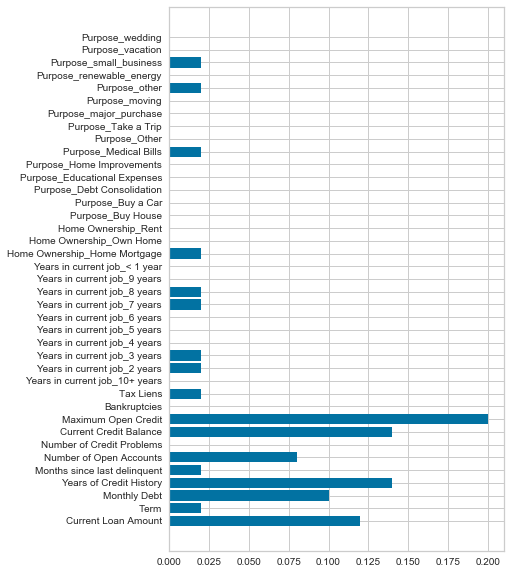

In [60]:
abc = AdaBoostClassifier(random_state=42)

abc.fit(X_train, y_train.ravel())

accuracy_train = abc.score(X_train, y_train)
accuracy_test = abc.score(X_test, y_test)

print('Train Accuracy', accuracy_train)
print('Test Accuracy', accuracy_test)

fig, ax = plt.subplots(figsize=(6, 10))
ax.barh(width=abc.feature_importances_, y=X_train.columns);

### <span style="color:blue">------------------------------------------XGBoostClassifier------------------------------------------</span>

In [67]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

accuracy_train = xgbc.score(X_train, y_train.ravel())
accuracy_test = xgbc.score(X_test, y_test.ravel())

print('Train Accuracy', accuracy_train)
print('Test Accuracy', accuracy_test)
fig, ax = plt.subplots(figsize=(6, 10))
ax.barh(width=xgbc.coef_[0], y=X_train.columns);

ValueError: feature_names must be string, and may not contain [, ] or <